In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd
import scipy.sparse as sps
%matplotlib inline  
%load_ext Cython

from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

In [2]:
class ItemKNNCFRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [3]:
# data_train_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv"
# data_target_user_path="/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv"
data_train_path="data_train.csv"
data_target_user_path="data_target_users_test.csv"
data_train = pd.read_csv(data_train_path)
data_target = pd.read_csv(data_target_user_path)

In [4]:
URM_all =  data_train.pivot(index='row', columns='col', values='data').fillna(0)
item_map = {i : item for i, item in enumerate(URM_all.columns)}
user_map = {i : user for i, user in enumerate(data_target["user_id"])}
item_map_inv = {item : i for i, item in item_map.items()}
user_map_inv = {user : i for i, user in user_map.items()}
missing_index = [x for x in range(1,13025) if x not in URM_all.index.tolist()]
add_urm = pd.DataFrame(index = missing_index, columns = URM_all.columns).fillna(0)
URM_all = pd.concat([URM_all, add_urm]).sort_index()
del add_urm
del missing_index
#data_target["user_id"] = data_target["user_id"]
URM_all = URM_all.to_numpy()
urm_sparse = sps.csr_matrix(URM_all)
urm_sparse

<13024x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [5]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(urm_sparse, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 3048 (23.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2598 (19.9%) Users that have less than 1 test interactions


In [6]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 22222 (100.0%), 2068.11 column/sec. Elapsed time 10.75 sec


In [7]:
import pandas as pd
from scipy.stats import loguniform
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "MAP"])
hyperparameter_search_rnd["k"] = loguniform.rvs(1, 200, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

for index in hyperparameter_search_rnd.index:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=hyperparameter_search_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    hyperparameter_search_rnd.loc[index,"MAP"] = result_df.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 815 ( 6.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 320 ( 1.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 3054.82 column/sec. Elapsed time 7.27 sec
EvaluatorHoldout: Processed 9976 (100.0%) in 9.09 sec. Users per second: 1097
ItemKNNCFRecommender: URM Detected 815 ( 6.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 320 ( 1.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 3376.73 column/sec. Elapsed time 6.58 sec
EvaluatorHoldout: Processed 9976 (100.0%) in 8.52 sec. Users per second: 1172
ItemKNNCFRecommender: URM Detected 815 ( 6.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 320 ( 1.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2852.78 column/sec. El

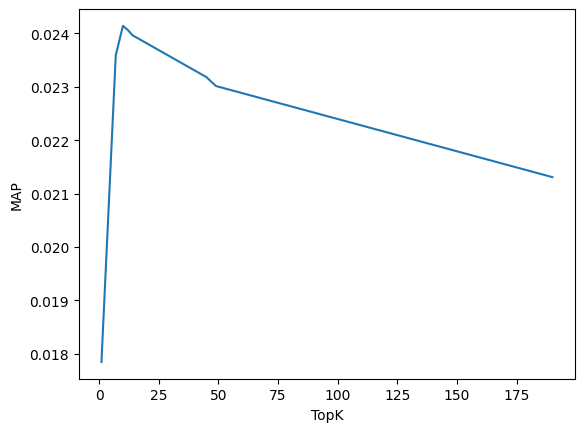

In [8]:
pyplot.plot(hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [9]:
hyperparameter_search_rnd

,k,MAP
5,1,0.017848
9,1,0.017848
8,7,0.023591
3,10,0.024141
0,12,0.024067
4,12,0.024067
10,12,0.024067
6,14,0.023967
1,45,0.023182
2,49,0.023015


In [10]:
best_k_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_k_value

hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = loguniform.rvs(0.1, 1000, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]

for index in hyperparameter_search_rnd.index:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=hyperparameter_search_rnd.loc[index,"shrink"], 
                    topK=hyperparameter_search_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    hyperparameter_search_rnd.loc[index, "MAP"] = result_df.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 815 ( 6.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 320 ( 1.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 3038.96 column/sec. Elapsed time 7.31 sec
EvaluatorHoldout: Processed 9976 (100.0%) in 6.00 sec. Users per second: 1663
ItemKNNCFRecommender: URM Detected 815 ( 6.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 320 ( 1.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 3049.43 column/sec. Elapsed time 7.29 sec
EvaluatorHoldout: Processed 9976 (100.0%) in 5.96 sec. Users per second: 1674
ItemKNNCFRecommender: URM Detected 815 ( 6.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 320 ( 1.4%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 3007.33 column/sec. El

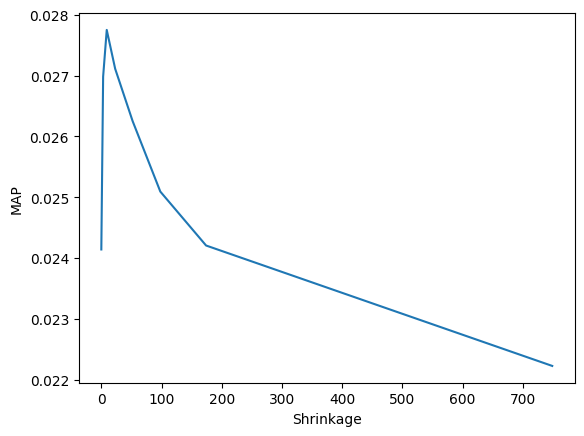

In [11]:
pyplot.plot(hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [12]:
best_parameters_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_parameters_value

k              10
shrink          9
MAP       0.02775
Name: 9, dtype: object

In [18]:
import time
recommender = ItemKNNCFRecommender(urm_sparse)
recommender.fit(shrink=best_parameters_value["shrink"], topK=best_parameters_value["k"])
n_users_to_test = len(data_target["user_id"])
suggestions = pd.DataFrame(columns = ["user_id", "item_list"])
start_time = time.time()

for user_id in (data_target["user_id"]-1):
    suggestion= recommender.recommend(user_id, cutoff=10)
    suggestions.loc[len(suggestions)] = [user_id+1, " ".join([str(item_map[x]) for x in suggestion])]
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 2489.41 column/sec. Elapsed time 8.93 sec
Reasonable implementation speed is 947.08 usr/sec


In [20]:
suggestions.to_csv('outputs/collaborative_item_item.csv', index=False)

In [19]:
suggestions

,user_id,item_list
0,1,36 101 506 515 403 1546 922 254 1422 1481
1,2,1095 47 11 28 50 136 277 1522 37 145
2,3,59 956 584 259 536 648 857 1281 414 2748
3,4,28 50 249 145 136 639 277 1146 1273 679
4,5,1570 77 116 5138 148 7033 175 238 9582 304
...,...,...
10877,13020,6198 6452 6450 6749 7394 7395 4323 161 506 15943
10878,13021,6179 6451 7027 6720 6749 7395 6426 6721 17942 ...
10879,13022,1668 1446 1411 1674 809 10789 21627 1258 8100 ...
10880,13023,639 1146 1124 1273 706 928 1534 1535 1107 1532
